In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [5]:
from proj1_helpers import *

DATA_TRAIN_PATH = '../../../Data-Project1/train.csv' # TODO: add a file Data-Project1 with the train data 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [6]:
# Initialize parameters
gamma = 1e-6
lambda_ = 0.001
max_iters = 100

## Attempt to preprocess the data and the features

In [7]:
# y must be 0 or 1 and not -1 or 1
def set_y(y):
    y = np.where(y == -1, 0, y)
    return y
y = set_y(y)

In [25]:
# Delete the outliers with the median
def delete_outliers(tX):
    for idx_feature in range(tX.shape[1]):
        tX_feature = tX[:,idx_feature]
        median = np.median(tX_feature[np.where(tX_feature != -999)])
        new = np.where(tX_feature == -999, median, tX_feature)
        tX[:, idx_feature] = np.copy(new)
    return tX

x = np.array([[0.2, 0.6, 0.8, 0.1, -999, 0.4, -999], [-999, 0.4, 0.8, -999, -999, 0.5, 0.6]])
x = x.T
tX = delete_outliers(tX)

In [26]:
from helpers import *

# Standardize the input data
stx, mean_stx, std_x = standardize(tX)

> Get rid of the Features that does not provide any more information than the background

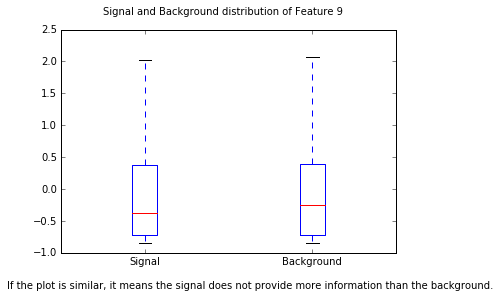

In [36]:
idx_f = 8
signal = stx[np.where(y == 1), idx_f + 1]
background = stx[np.where(y == 0), idx_f + 1]

plot = plt.figure()
plt.boxplot([signal, background], 0, '')
plt.xticks([1, 2], ['Signal', 'Background'])
plot.suptitle('Signal and Background distribution of Feature {f}'.format(f = idx_f + 1))

textvar = plot.text(0, 0, 'If the plot is similar, it means the signal does not provide more information than the background.')

> Compute the correlation between features

In [114]:
def calculate_correlation(stx):
    corr = np.ones((stx.shape[1]-1, stx.shape[1]-1))
    for feature1 in range(1, stx.shape[1]):
        for feature2 in range(1, stx.shape[1]):
            corr[feature1-1, feature2-1] = np.corrcoef(stx[:, feature1], stx[:, feature2])[0, 1]
            if (corr[feature1-1, feature2-1] >= 0.9 and feature1-1 != feature2-1):
                
                print("Features {f1} and {f2} are highly correlated: {corr}".format(f1 =feature1-1, f2 = feature2-1, corr = corr[feature1-1, feature2-1]))
    return corr

In [121]:
corr = calculate_correlation(stx)
idx_to_del = np.array([22, 30])

Features 9 and 21 are highly correlated: 0.9044814595684958
Features 9 and 29 are highly correlated: 0.9656283889163997
Features 21 and 9 are highly correlated: 0.9044814595684957
Features 29 and 9 are highly correlated: 0.9656283889163997


In [115]:
def calculate_correlation_with_y(stx, y):
    corr = np.ones(stx.shape[1]-1)
    for feature in range(1, stx.shape[1]):
        corr[feature-1] = np.corrcoef(y, stx[:, feature])[0, 1] 
        if (abs(corr[feature-1]) <= 0.01):
            print("feature {f} is not correlated with y: {corr}".format(f = feature, corr= corr[feature-1]))
    return corr

In [122]:
corr = calculate_correlation_with_y(stx, y)
idx_to_del = np.append(idx_to_del, [16,17,19,20,26,27,29])

feature 15 is not correlated with y: -0.0009432510582117535
feature 16 is not correlated with y: -0.00440253868638843
feature 18 is not correlated with y: 0.001516235377059733
feature 19 is not correlated with y: 0.00412544741152486
feature 21 is not correlated with y: 0.007475342188590247
feature 25 is not correlated with y: 7.15909820593841e-05
feature 26 is not correlated with y: 0.0009043288374294407
feature 28 is not correlated with y: 0.0005721318815439868
feature 29 is not correlated with y: -0.003524581655021693


In [132]:
idx_to_del = np.sort(idx_to_del)
idx_to_del = idx_to_del[::-1]
print(idx_to_del)

[30 29 27 26 22 20 19 17 16]


In [133]:
def delete_features(stx):
    return np.delete(stx, idx_to_del, 1)

clean_tx = delete_features(stx)
calculate_correlation_with_y(clean_tx, y)

feature 15 is not correlated with y: -0.0009432510582117535
feature 16 is not correlated with y: 0.001516235377059733
feature 17 is not correlated with y: 0.007475342188590247
feature 20 is not correlated with y: 7.15909820593841e-05
feature 21 is not correlated with y: 0.0005721318815439868


array([ 0.0263822 , -0.35142796, -0.01405527,  0.19252633,  0.20347244,
        0.21249463, -0.18361342,  0.01224548, -0.01528743,  0.15323593,
       -0.1953979 ,  0.27175188,  0.17514537,  0.23523798, -0.00094325,
        0.00151624,  0.00747534,  0.13354912,  0.11545223,  0.00007159,
        0.00057213])

## Linear regression using Gradient Descent 

In [10]:
from costs import *

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y - tx @ w
    return -(tx.T @ e)/len(y)

def least_squares_GD(y, tx, gamma, max_iters):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    w = np.zeros(tx.shape[1])
    ws = [np.copy(w)]
    losses = []
    for n_iter in range(max_iters):
        # compute gradient with mse
        grad = compute_gradient(y, tx, w)
        
        # update w
        w = w - (gamma*grad)
        
        # calculate the cost with mse
        loss = compute_loss(y, tx, w)
        
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}".format(
              bi=n_iter, ti=max_iters - 1, l=loss))
    print("Optimal weights: {w}".format(w=ws[tx.shape[1]]))
    return losses, ws

least_squares_GD(y, stx, gamma, max_iters)

Gradient Descent(0/99): loss=0.17133373316438974
Gradient Descent(1/99): loss=0.17133346633065805
Gradient Descent(2/99): loss=0.1713331994988049
Gradient Descent(3/99): loss=0.17133293266883035
Gradient Descent(4/99): loss=0.17133266584073426
Gradient Descent(5/99): loss=0.17133239901451672
Gradient Descent(6/99): loss=0.17133213219017765
Gradient Descent(7/99): loss=0.17133186536771702
Gradient Descent(8/99): loss=0.17133159854713473
Gradient Descent(9/99): loss=0.17133133172843099
Gradient Descent(10/99): loss=0.1713310649116055
Gradient Descent(11/99): loss=0.17133079809665852
Gradient Descent(12/99): loss=0.17133053128358966
Gradient Descent(13/99): loss=0.1713302644723993
Gradient Descent(14/99): loss=0.17132999766308707
Gradient Descent(15/99): loss=0.17132973085565312
Gradient Descent(16/99): loss=0.17132946405009739
Gradient Descent(17/99): loss=0.17132919724641998
Gradient Descent(18/99): loss=0.1713289304446206
Gradient Descent(19/99): loss=0.17132866364469948
Gradient Desce

([0.17133373316438974,
  0.17133346633065805,
  0.17133319949880491,
  0.17133293266883035,
  0.17133266584073426,
  0.17133239901451672,
  0.17133213219017765,
  0.17133186536771702,
  0.17133159854713473,
  0.17133133172843099,
  0.17133106491160549,
  0.17133079809665852,
  0.17133053128358966,
  0.1713302644723993,
  0.17132999766308707,
  0.17132973085565312,
  0.17132946405009739,
  0.17132919724641998,
  0.17132893044462061,
  0.17132866364469948,
  0.17132839684665646,
  0.17132813005049152,
  0.17132786325620469,
  0.17132759646379592,
  0.17132732967326517,
  0.17132706288461244,
  0.17132679609783769,
  0.1713265293129409,
  0.17132626252992203,
  0.17132599574878116,
  0.17132572896951806,
  0.17132546219213288,
  0.1713251954166255,
  0.171324928642996,
  0.17132466187124426,
  0.17132439510137026,
  0.17132412833337404,
  0.17132386156725546,
  0.17132359480301471,
  0.17132332804065151,
  0.17132306128016594,
  0.17132279452155807,
  0.17132252776482776,
  0.171322261009

## Lienear regression using stochastic gradient descent

In [ ]:
def least_squares_SGD(y, tx, gamma, max_iters):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    w = np.zeros(tx.shape[1])
    ws = [np.copy(w)]
    losses = []
    batch_size = 50000
    
    for n_iter in range(max_iters):
        # compute gradient for each ini batch
        a = 0;
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size, num_batches=1):
            grad = compute_gradient(minibatch_y, minibatch_tx, w)
            
            # upgrade w
            w = w - (gamma*grad)

            # compute loss with mse
            loss = compute_loss(y, tx, w)

            # store w and loss
            ws.append(np.copy(w))
            losses.append(loss)
    print("Optimal weights: {w}\n\n Loss: {l}".format(w=ws[tx.shape[1]], l = loss))
    return losses, ws

losses, ws = least_squares_SGD(y, stx, gamma, max_iters)
w_LSSGD = ws[-1]
w_LSSGD = w_LSSGD[1:]

## Least squares regression using normal equations

In [6]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    return w, compute_loss(y, tx, w)

least_squares(y, stx)

NameError: name 'compute_loss' is not defined

## Ridge regression using normal equations

In [11]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    w = np.linalg.solve((tx.T @ tx) + lamb*np.eye(tx.shape[1]), tx.T @ y)
    return w, compute_loss(y, tx, w)

lamb = 0
weights, loss = ridge_regression(y, stx, lamb)
weights = weights[1:]
print(loss)

0.0847539968353


## Logistic regression using gradient or SGD

In [16]:
def sigmoid(t):
    """apply sigmoid function on t."""
    # equivalent to use 1/(1+exp(-t)) but avoids overflow
    return np.exp(-np.logaddexp(0, -t))

In [17]:
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    #for n in range(N):
    #   cost += np.log(1+np.exp(tx[n, :].T @ w)) - (y[n] * tx[n, :].T @ w)
    y = y.reshape((-1, 1))
    return np.sum(np.logaddexp(0, tx @ w)) - y.T @ (tx @ w)

In [18]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    sig = sigmoid(tx @ w)
    sig = sig.reshape(sig.shape[0],)
    return tx.T @ (sig - y)

In [19]:
def learning_by_gradient_descent(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_loss(y, tx, w) + lambda_* (w.T @ w)
    gradient = calculate_gradient(y, tx, w)
    
    w.shape = (w.shape[0],)
    w = w - gamma * gradient
    return loss, w

In [27]:
def logistic_regression(y, tx, gamma, max_iters):
    """
    Logistic regression using GD
    """
    # init parameters
    threshold = 0.001
    losses = []

    # build w
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma, lambda_ = 0)
        # log info
        if iter % 500 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria ( max_iters is really high)
        losses.append(np.copy(loss))
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return loss, w

max_iters = 10000
loss_LR, w_LR = logistic_regression(y, stx, gamma, max_iters)

Current iteration=0, the loss=[[ 173286.79513999]]
Current iteration=500, the loss=[ 125035.13449843]
Current iteration=1000, the loss=[ 124696.02273402]
Current iteration=1500, the loss=[ 124650.36069584]
Current iteration=2000, the loss=[ 124642.50560427]
Current iteration=2500, the loss=[ 124640.58234911]
Current iteration=3000, the loss=[ 124639.81845564]


## Regularized  logistic  regression  using  gradient  descent or SGD

In [ ]:
def reg_logistic_regression(y, tx, lambda_, gamma, max_iters):
    """
    Logistic regression using GD
    """
    # init parameters
    threshold = 0.01
    losses = []

    # build w
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma, lambda_)
        # log info
        if iter % 500 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria ( max_iters is really high)
        losses.append(np.copy(loss))
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return loss, w

reg_logistic_regression(y, stx, lambda_, gamma, max_iters)

## Cross Validation

Take the minimum of rmse_te

[0.41234783128748775,
 0.41234782100292378,
 0.41234781460896169,
 0.4123478106357924,
 0.41234780816724736,
 0.41234780663328113,
 0.41234780567941354,
 0.41234780508513741,
 0.41234780471304638,
 0.4123478044770974,
 0.41234780432272639,
 0.41234780421423439,
 0.41234780412653538,
 0.41234780403935972,
 0.41234780393257964,
 0.4123478037815872,
 0.41234780355168965,
 0.41234780319030878,
 0.41234780261540083,
 0.41234780169798368,
 0.41234780023620121,
 0.41234779791873372,
 0.41234779427895352,
 0.4123477886547493,
 0.41234778021072477,
 0.41234776819824576,
 0.41234775295191278,
 0.41234773897645488,
 0.41234774369737781,
 0.41234782109928414]

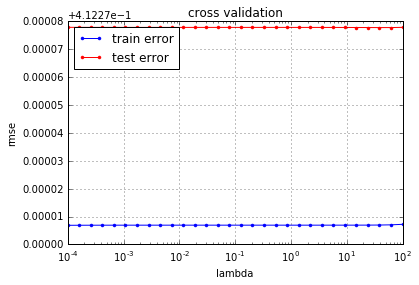

In [33]:
from cross_validation import *
seed = 1
k_fold = 4
lambdas = np.logspace(-4, 2, 30)
cross_validation_demo(y, stx, k_fold, lambdas, seed)

## Generate predictions and save ouput in csv format for submission:

In [28]:
DATA_TEST_PATH = '../../../Data-Project1/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [29]:
tX_test = delete_outliers(tX_test)

In [30]:
stx_test, mean_stx_test, std_x_test = standardize(tX_test)

In [31]:
OUTPUT_PATH = '../../../Data-Project1/Data_submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_LR, stx_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)